Find Changepoints
==========

I want to see the effect of a station closing or opening on the other stations in the system, most likely those stations either linked to it on the same line or those that are physically closer to each other.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

user = 'mikemoran'
database = 'stations'

In [2]:
engine = create_engine(f'postgres://{user}@localhost/{database}')
conn = psycopg2.connect(database=database, user=user)

Get station details, so we know what the `c_a` field relates to and which tables we need to pull.

In [6]:
query = '''
    select * from station_info;
'''

station_details = pd.read_sql(query, conn)
station_details.drop('index', axis=1, inplace=True)
station_details.head()

,unit,station,linename,c_a
0,R001,SOUTH FERRY,1R,R101
1,R001,SOUTH FERRY,1RW,R101
2,R001,WHITEHALL S-FRY,R1,A058
3,R001,WHITEHALL S-FRY,R1,A060
4,R001,WHITEHALL S-FRY,R1W,A058


In [7]:
station_details[station_details.station.str.contains('2 AV')]

,unit,station,linename,c_a
790,R300,2 AV,F,N521
791,R300,2 AV,F,N523
792,R300,2 AVE,F,N521
793,R300,2 AVE,F,N523
958,R394,BAY PKY-22 AVE,N,D010
959,R394,BAY PKY-22 AVE,N,D011
1006,R422,22 AVE-BAY PKY,F,N553
1123,R570,72 ST-2 AVE,Q,N700
1124,R570,72 ST-2 AVE,Q,N700A
1125,R571,86 ST-2 AVE,Q,N701


In [12]:
station_details[#(station_details.linename == '456') &
                (station_details.station.str.contains('LEX'))].sort_values('station')

,unit,station,linename,c_a
50,R016,LEXINGTON AV/53,EM6,N305A
53,R017,LEXINGTON AV/53,EM6,N305
54,R017,LEXINGTON AV/53,EM6,N306
820,R319,LEXINGTON AV/63,F,N601
821,R319,LEXINGTON AV/63,F,N601A
173,R051,LEXINGTON AVE,NQR456,A002
822,R319,LEXINGTON AVE,F,N601
49,R016,LEXINGTON-53 ST,EM6,N305A
51,R017,LEXINGTON-53 ST,EM6,N305
52,R017,LEXINGTON-53 ST,EM6,N306


In [15]:
# loaded = '''  # loaded in, but don't want the cell contents

In [21]:
c_a_needed = ['N700', 'N700A', 'N701', 'N701A', 'N702', 'N702A',  # Q
              'R246', 'R247', 'R248', 'R249', 'R250', 'R251', 'R252',  # 456
              'R253', 'R254', 'R256', 'R257', 'R258',  # 456
              'A002', 'N601', 'N601A']  # Lex/59 + Lex/63

In [22]:
[c_a in loaded for c_a in c_a_needed]

[False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False]

OK, we don't have all of the new data yet... We're missing the 2nd Ave subway stations (which is fine since we have all of that data anyway), and missing Lex/63. That is more problematic, but we can work with this. I just want to use my old data for now anyway, since I have stations spread across multiple control areas (which I thought were higher priority than units), so I would need to merge a whole bunch of stuff anyway.

In [23]:
tables = ['second72', 'second86', 'second96',
          'g68', 'g77', 'g86', 'g96',
          'g103', 'g110', 'g116', 'g125']
renames = ['s72', 's86', 's96',
           'g68', 'g77', 'g86', 'g96',
           'g103', 'g110', 'g116', 'g125']

select = '{}.d_entries {}_in, {}.d_exits {}_out'
joins = 'left join {} {} on l.date = {}.date'

select_parts = ['select l.date, l.d_entries l_in, l.d_exits l_out']
join_parts = ['from lexington l']
for old, new in zip(tables, renames):
    new_select = select.format(new, new, new, new)
    select_parts.append(new_select)
    new_join = joins.format(old, new, new)
    join_parts.append(new_join)
select_str = ',\n'.join(select_parts)
query = '\n'.join([select_str, *join_parts, ';'])
print(query)

select l.date, l.d_entries l_in, l.d_exits l_out,
s72.d_entries s72_in, s72.d_exits s72_out,
s86.d_entries s86_in, s86.d_exits s86_out,
s96.d_entries s96_in, s96.d_exits s96_out,
g68.d_entries g68_in, g68.d_exits g68_out,
g77.d_entries g77_in, g77.d_exits g77_out,
g86.d_entries g86_in, g86.d_exits g86_out,
g96.d_entries g96_in, g96.d_exits g96_out,
g103.d_entries g103_in, g103.d_exits g103_out,
g110.d_entries g110_in, g110.d_exits g110_out,
g116.d_entries g116_in, g116.d_exits g116_out,
g125.d_entries g125_in, g125.d_exits g125_out
from lexington l
left join second72 s72 on l.date = s72.date
left join second86 s86 on l.date = s86.date
left join second96 s96 on l.date = s96.date
left join g68 g68 on l.date = g68.date
left join g77 g77 on l.date = g77.date
left join g86 g86 on l.date = g86.date
left join g96 g96 on l.date = g96.date
left join g103 g103 on l.date = g103.date
left join g110 g110 on l.date = g110.date
left join g116 g116 on l.date = g116.date
left join g125 g125 on l.date =

In [24]:
user = 'mikemoran'
host = 'localhost'
dbname = 'stations'

engine = create_engine(f'postgres://{user}@{host}/{dbname}')
conn = None
conn = psycopg2.connect(database=dbname, user=user)

df = pd.read_sql(query, conn)
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df_modern = df[df.date >= pd.datetime(2016, 1, 1)]
df, df_modern = df_modern, df
df.set_index('date', drop=True, inplace=True)
df.sort_index(inplace=True)
df.head()

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g96_in,g96_out,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,3302.0,3146.0,NaN,NaN,NaN,NaN,NaN,NaN,9521.0,7198.0,...,10097.0,2628.0,7678.0,7633.0,5749.0,5347.0,9343.0,5262.0,9084.0,13426.0
2016-01-02,4254.0,3987.0,NaN,NaN,NaN,NaN,NaN,NaN,4706.0,5430.0,...,6141.0,2913.0,6481.0,6787.0,5359.0,4253.0,7507.0,2970.0,10346.0,17843.0
2016-01-03,4173.0,3275.0,NaN,NaN,NaN,NaN,NaN,NaN,3401.0,4513.0,...,3682.0,2294.0,5143.0,6098.0,4219.0,3907.0,6427.0,2747.0,9516.0,17188.0
2016-01-04,8824.0,7496.0,NaN,NaN,NaN,NaN,NaN,NaN,28379.0,19186.0,...,24008.0,4968.0,14419.0,13755.0,12151.0,9270.0,15698.0,8035.0,19381.0,23519.0
2016-01-05,9622.0,7700.0,NaN,NaN,NaN,NaN,NaN,NaN,31805.0,19920.0,...,25705.0,5205.0,15140.0,14409.0,12226.0,9137.0,15590.0,8412.0,19085.0,23511.0


Focus just on people getting onto the subway, daily.

In [191]:
df = (pd.read_sql_query(query, conn, parse_dates=['date'])
        .set_index('date', drop=True)
        .sort_index())
df.head()

,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g96_in,g96_out,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,7398.0,4184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10332.0,3020.0,7831.0,6480.0,5881.0,5543.0,8977.0,5411.0,9688.0,13648.0
2015-01-02,13755.0,8050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17519.0,4936.0,12518.0,9128.0,9714.0,8037.0,12870.0,7255.0,15926.0,20103.0
2015-01-03,8138.0,3522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11078.0,3331.0,9013.0,7069.0,7063.0,6007.0,10039.0,6111.0,11807.0,17263.0
2015-01-04,5495.0,2569.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8787.0,2849.0,6949.0,5588.0,5705.0,5248.0,8752.0,5137.0,9418.0,13796.0
2015-01-05,16799.0,10314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25469.0,6281.0,16839.0,19310.0,12307.0,9612.0,16164.0,8888.0,20581.0,24833.0


In [26]:
ins = [c for c in df.columns if c.endswith('in')]
df_ins = df[ins]
df_ins.head()

,l_in,s72_in,s86_in,s96_in,g68_in,g77_in,g86_in,g96_in,g103_in,g110_in,g116_in,g125_in
date,,,,,,,,,,,,
2016-01-01,3302.0,NaN,NaN,NaN,9521.0,13959.0,26667.0,10097.0,7678.0,5749.0,9343.0,9084.0
2016-01-02,4254.0,NaN,NaN,NaN,4706.0,6840.0,49838.0,6141.0,6481.0,5359.0,7507.0,10346.0
2016-01-03,4173.0,NaN,NaN,NaN,3401.0,5023.0,37991.0,3682.0,5143.0,4219.0,6427.0,9516.0
2016-01-04,8824.0,NaN,NaN,NaN,28379.0,32531.0,62803.0,24008.0,14419.0,12151.0,15698.0,19381.0
2016-01-05,9622.0,NaN,NaN,NaN,31805.0,36193.0,64324.0,25705.0,15140.0,12226.0,15590.0,19085.0


Now, try to automatically detect the changepoint (Jan 1 2017) within the data...

Index(['l_in', 's72_in', 's86_in', 's96_in', 'g68_in', 'g77_in', 'g86_in',
       'g96_in', 'g103_in', 'g110_in', 'g116_in', 'g125_in'],
      dtype='object')


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


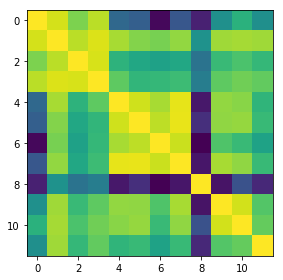

In [29]:
plt.imshow(df_ins.corr())
print(df_ins.columns)

In [30]:
# test with just lexington's data

import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
#     alpha = 1.0/df_ins.l_in.mean()
#     lambda_1 = pm.Exponential('lambda_1', alpha)
#     lambda_2 = pm.Exponential('lambda_2', alpha)
    mu = df_ins.l_in.mean()
    lambda_1 = pm.Poisson('lambda_1', mu)
    lambda_2 = pm.Poisson('lambda_2', mu)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=df_ins.shape[0])

In [31]:
with model:
    idx = np.arange(df_ins.shape[0])  # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [32]:
with model:
    observation = pm.Poisson('obs', lambda_, observed=df_ins.l_in.values)

In [33]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=500, step=step)

100%|██████████| 1000/1000 [00:00<00:00, 1453.62it/s]


In [34]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


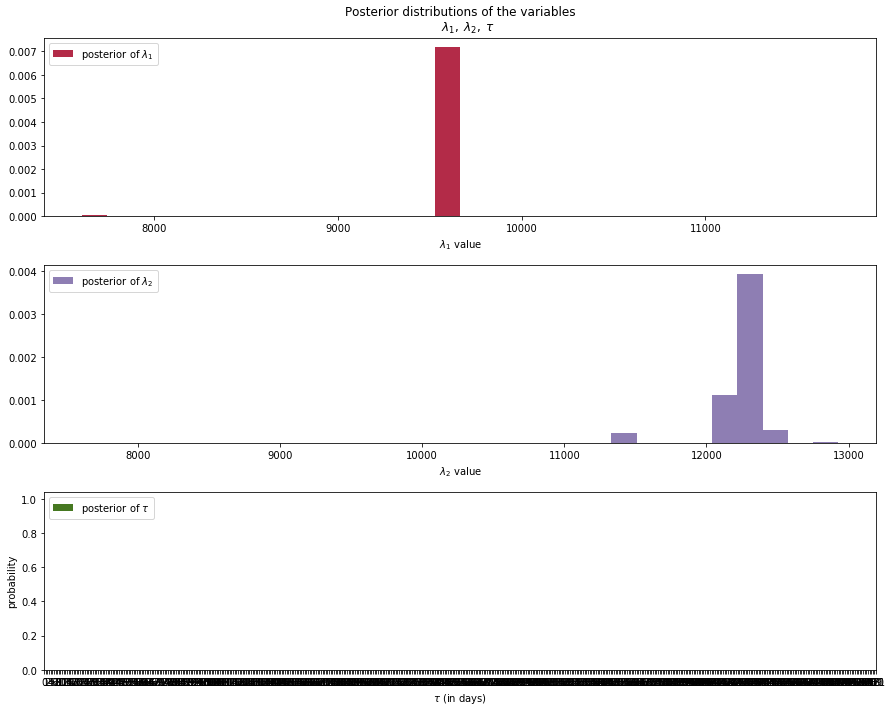

In [40]:
from IPython.core.pylabtools import figsize
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
# ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
# plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
# ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
# plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=df_ins.l_in.shape[0], alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(df_ins.l_in.shape[0]))

plt.legend(loc="upper left")
# plt.ylim([0, .75])
# plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


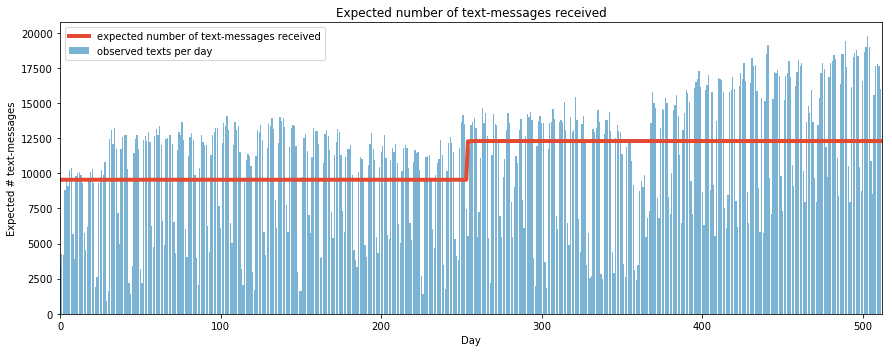

In [44]:
n_count_data = df_ins.l_in.shape[0]

figsize(12.5, 5)
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
# plt.ylim(0, 60)
plt.bar(np.arange(df_ins.l_in.shape[0]), df_ins.l_in.values, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")

In [45]:
import sys
sys.version

'3.6.1 |Continuum Analytics, Inc.| (default, Mar 22 2017, 19:54:23) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [161]:
def get_model_results(data, sample=1000, tune=500):
    with pm.Model() as model:
#         alpha = 1.0/data.mean()
#         lambda_1 = pm.Exponential('lambda_1', alpha)
#         lambda_2 = pm.Exponential('lambda_2', alpha)
        mu = data.mean()
        lambda_1 = pm.Poisson('lambda_1', mu)
        lambda_2 = pm.Poisson('lambda_2', mu)

        tau = pm.DiscreteUniform('tau', lower=0, upper=data.shape[0])
        idx = np.arange(data.shape[0])  # Index
        lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=data.values)
        step = pm.Metropolis()
        trace = pm.sample(sample, tune=tune, step=step)
    return trace

In [146]:
def plot_trace(trace, data):
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    
    ax = plt.subplot(311)
    # ax.set_autoscaley_on(False)

    max_val = (data.max() // 1000 + 1) * 1000
    bin_size = max_val // 50
    
    plt.hist(lambda_1_samples, histtype='stepfilled', bins=np.arange(0, max_val, bin_size), alpha=0.85,
             label="posterior of $\lambda_1$", color="#A60628", normed=True)
    plt.legend(loc="upper left")
    plt.title(r"""Posterior distributions of the variables
        $\lambda_1,\;\lambda_2,\;\tau$""")
    plt.xlabel("$\lambda_1$ value")

    ax = plt.subplot(312)
    plt.hist(lambda_2_samples, histtype='stepfilled', bins=np.arange(0, max_val, bin_size), alpha=0.85,
             label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
    plt.legend(loc="upper left")
    plt.xlabel("$\lambda_2$ value")

    plt.subplot(313)
    w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
    plt.hist(tau_samples, bins=data.shape[0], alpha=1,
             label=r"posterior of $\tau$",
             color="#467821", weights=w, rwidth=2.)
    plt.xlim(0, data.shape[0])

    plt.legend(loc="upper left")
    plt.xlabel(r"$\tau$")
    plt.ylabel("probability")
    plt.show()

In [139]:
def plot_verify(trace, data):
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    
    N = tau_samples.shape[0]
    expected_per_day = np.zeros(data.shape[0])
    for day in range(0, data.shape[0]):
        ix = day < tau_samples
        expected_per_day[day] = (lambda_1_samples[ix].sum()
                                       + lambda_2_samples[~ix].sum()) / N
    plt.plot(range(data.shape[0]), expected_per_day, lw=4, color="#E24A33",
             label="expected number of text-messages received")
    plt.xlabel("Day")
    plt.ylabel("Expected passengers")
    plt.title("Expected number of passengers")
    plt.bar(np.arange(data.shape[0]), data.values, color="#348ABD", alpha=0.65,
            label="observed passengers per day")
    plt.legend(loc="upper left")
    plt.show()

In [140]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

np.median(lambda_1_samples), np.median(lambda_2_samples), np.median(tau_samples)

(17490.250378419649, 21442.436086932812, 176.0)

In [141]:
data.shape[0]

182

In [167]:
def get_model_results(data, sample=1000, tune=500):
    with pm.Model() as model:
        alpha = 1.0/data.mean()
        lambda_1 = pm.Exponential('lambda_1', alpha)
        lambda_2 = pm.Exponential('lambda_2', alpha)
        tau = pm.DiscreteUniform('tau', lower=0, upper=data.shape[0])
        
        idx = np.arange(data.shape[0])  # Index
        lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=data.values)
        
        step = pm.Metropolis()
        trace = pm.sample(sample, tune=tune, step=step)
    return trace

In [181]:
df.index.get_loc('2017-01-01')

366

In [182]:
slice_size = [10, 20, 30, 40, 50, 60, 70, 80, 90]  # days
expected_tau = df.index.get_loc('2017-01-01')
windows = [slice(expected_tau - s, expected_tau + s) for s in slice_size]
# window = slice('2016-10-01', '2017-03-31')

def prediction(window):
    saved_traces = []
    for station in ins:
        data = df[station].fillna(0)
        data = data.iloc[window]
        trace = get_model_results(data, sample=10000, tune=5000)
        saved_trace.append(trace)
    return saved_traces

def run_all():
    results = []
    for w in windows:
        print(w)
        results.append(prediction(w))
#     results = [prediction(w) for w in windows]
    return results

all_results = run_all()

slice(356, 376, None)


100%|██████████| 10000/10000 [00:02<00:00, 3549.62it/s]


slice(346, 386, None)

100%|██████████| 10000/10000 [00:02<00:00, 3595.57it/s]



slice(336, 396, None)


100%|██████████| 10000/10000 [00:02<00:00, 3668.99it/s]
INFO (theano.gof.compilelock): Refreshing lock /home/mikemoran/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.1-64/lock_dir/lock


slice(326, 406, None)


AssertionError: 

In [187]:
trace_df = (pd.DataFrame({'station':ins, 'l1':saved_l1, 'l2':saved_l2})
            .set_index('station'))
#             .transpose())
trace_df['p_diff'] = trace_df.diff(axis=1)['l2']
trace_df['elas'] = trace_df.p_diff / trace_df.l1
trace_df

,l1,l2,p_diff,elas
station,,,,
l_in,10043.0,13411.0,3368.0,0.335358
s72_in,1.0,21388.0,21387.0,21387.000000
s86_in,1.0,20012.0,20011.0,20011.000000
s96_in,1.0,13269.0,13268.0,13268.000000
g68_in,29626.0,20205.0,-9421.0,-0.317998
g77_in,30877.0,23832.0,-7045.0,-0.228163
g86_in,56353.0,39598.0,-16755.0,-0.297322
g96_in,22697.0,16287.0,-6410.0,-0.282416
g103_in,14039.0,12137.0,-1902.0,-0.135480


Elasticity
------------

After speaking with Jesse, I can find the joint elasticity between stations, or (in my case) the joint elasticity between the 456 stations and the new Q extension. Since those stations opened as a whole, I can't really separate out their effects from each other.

Elasticity is the change in quantity sold of an item for a given change in price of that item. In my case, the quantity sold is ridership (number of riders entering a given station), and the price of that item is a "human" price (weather, walking distance, preference, etc.) that I cannot define for everyone. The shock events of opening a station changes the supply of subway rides available, and the new station has a cost associated with it for each person. For those people where the cost of the new station(s) is less than the other stations, they will switch stations, and the riders serviced by each will respond based on the elasticity for those stations when looked at on the whole.

Our model is still the `pymc3` one, where the hyperparameter we're tuning is the window around the shock event to use.

l_in


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


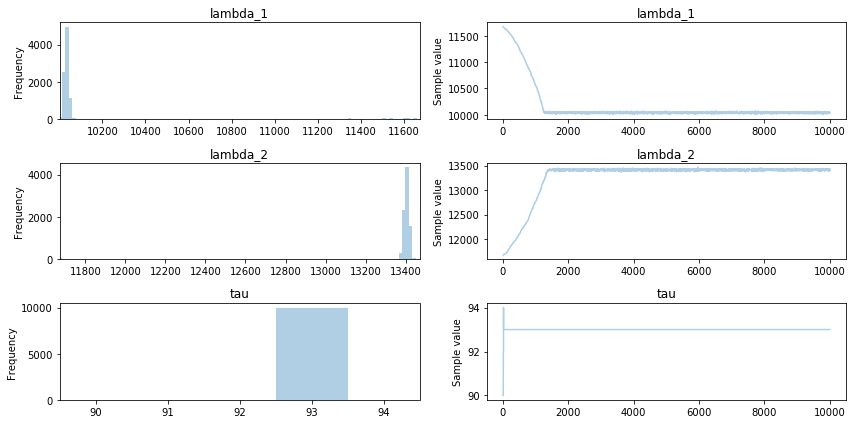

s72_in


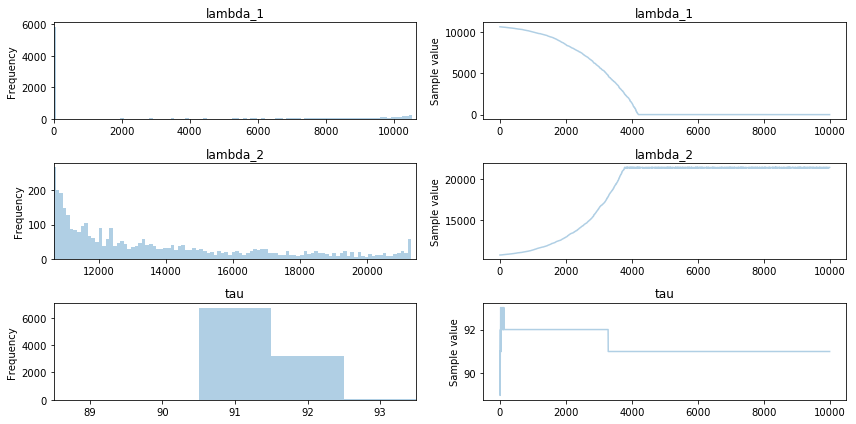

s86_in


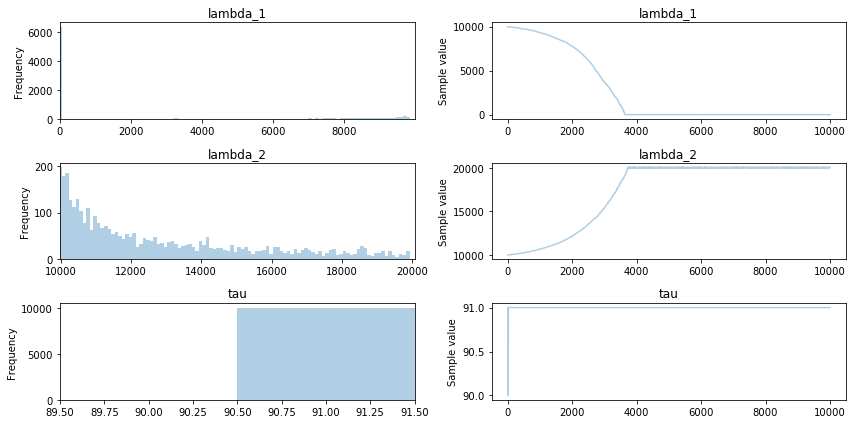

s96_in


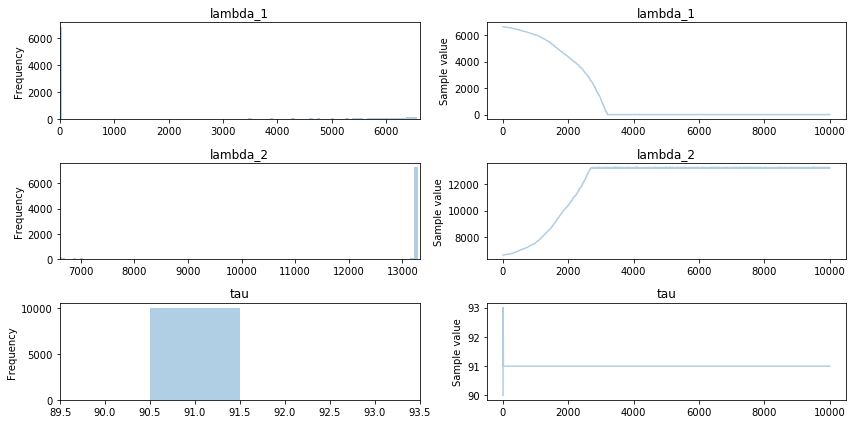

g68_in


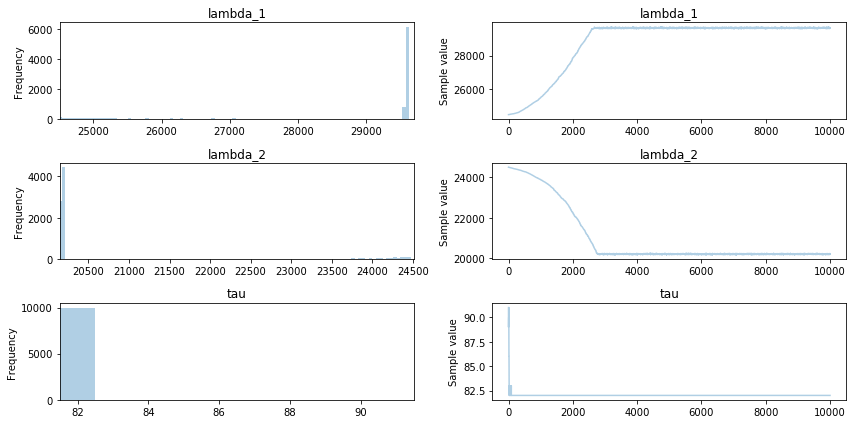

g77_in


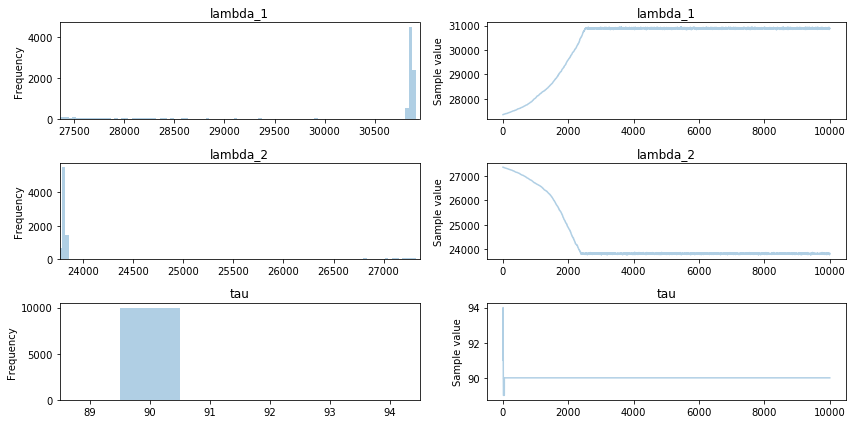

g86_in


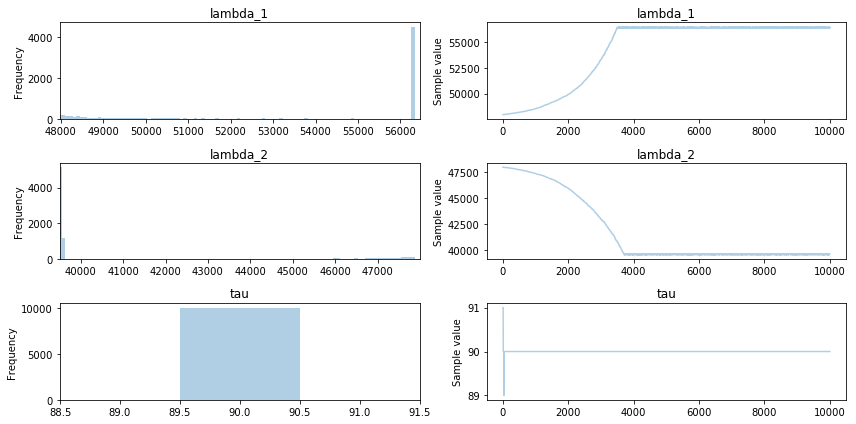

g96_in


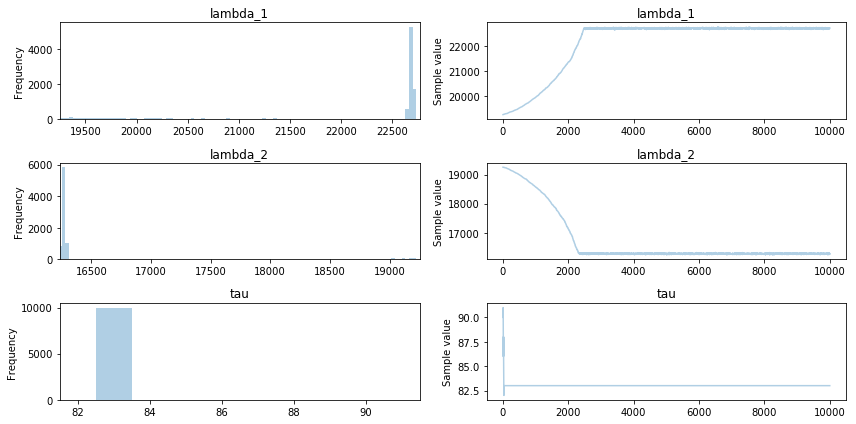

g103_in


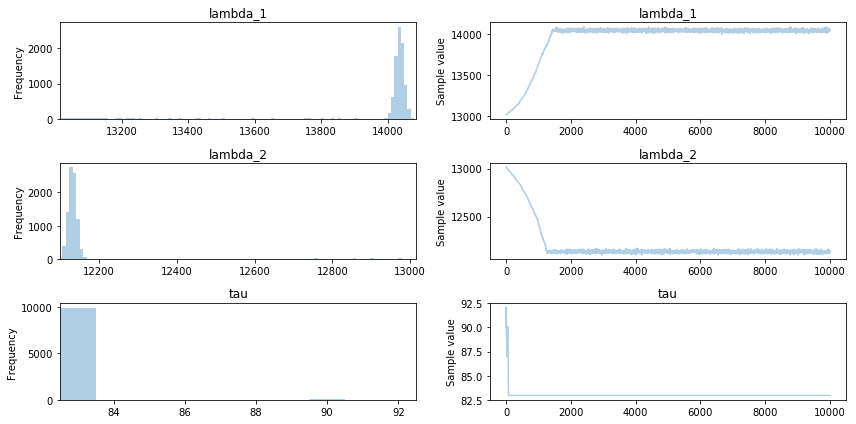

g110_in


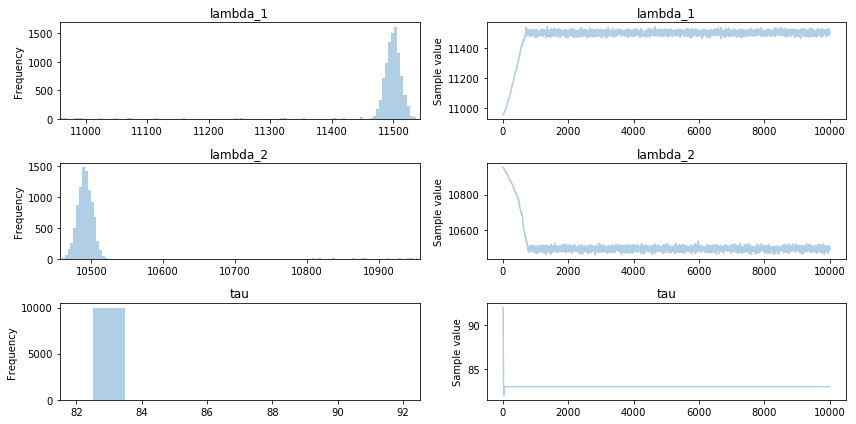

g116_in


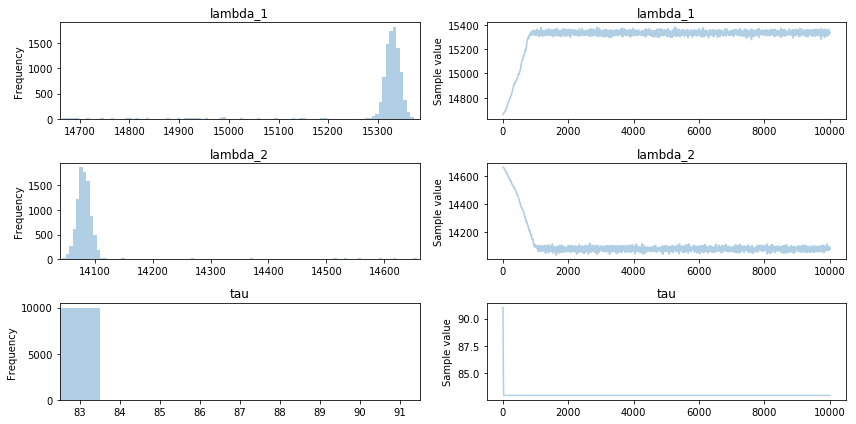

g125_in


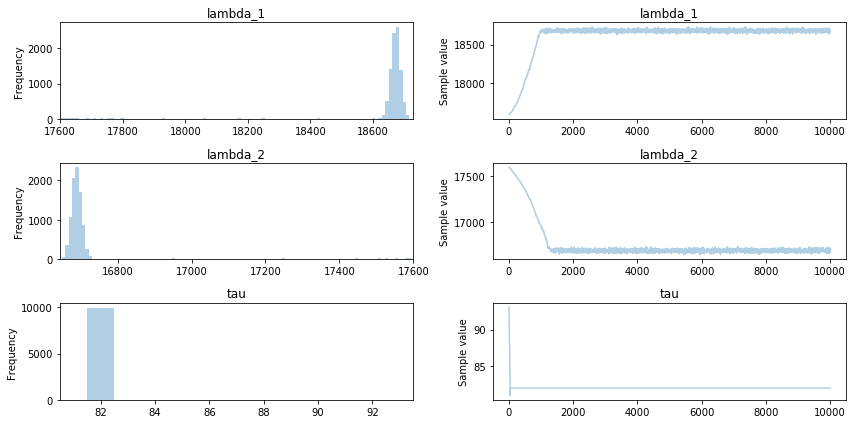

In [165]:
for i, (trace, name) in enumerate(zip(saved_trace, ins)):
    print(name)
    _ = pm.traceplot(saved_trace[i])
    plt.show()

In [207]:
test_701a = (pd.read_sql('select * from "N701A";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701 = (pd.read_sql('select * from "N701";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701.head()

,c_a,unit,scp,station,linename,dentries,dexits
date_time,,,,,,,
2016-12-31 00:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,NaN,NaN
2016-12-31 04:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 08:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 12:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 16:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,1.0,4.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


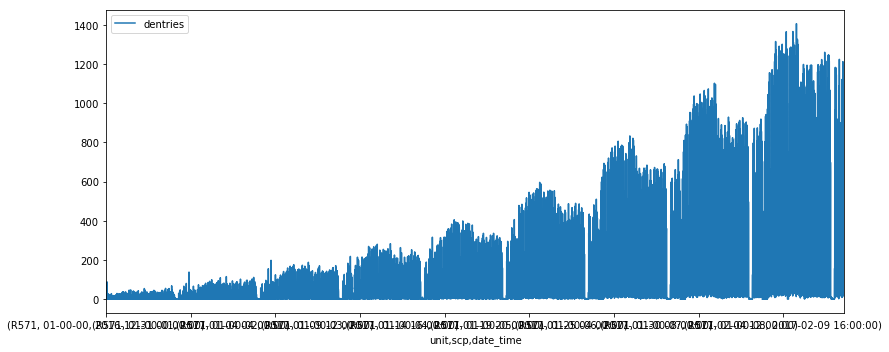

In [213]:
summed_701a = test_701a.groupby(['unit', 'scp', 'date_time']).sum()
summed_701a.dentries = np.abs(summed_701a.dentries)
summed_701a[summed_701a.dentries > 30000] = np.NaN
summed_701a.plot.line(y='dentries')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


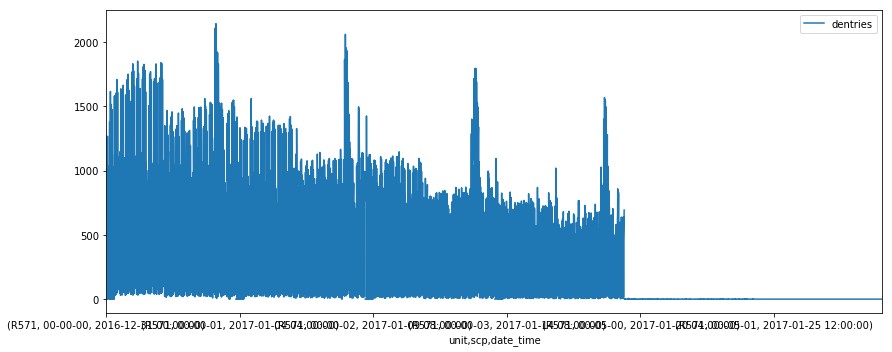

In [211]:
summed_701 = test_701.groupby(['unit', 'scp', 'date_time']).sum()
summed_701.dentries = np.abs(summed_701.dentries)
summed_701[summed_701.dentries > 30000] = np.NaN
summed_701.plot.line(y='dentries')

In [218]:
summed_701.join(summed_701a, on='date_time', how='right').head()

ValueError: len(left_on) must equal the number of levels in the index of "right"